In [152]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from scipy.stats import skew

pd.options.display.max_columns = 500

Снова потренируемся в предсказании цен на недвижимость из [очередного датасета с каггла](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/)! В качестве основной метрики для валидации моделей будем использовать, как и ранее, `MSLE`.

P.S. в данной домашней работе при построении любых моделей, использующих недетерменированные элементы (как бутстрап), в алгоритме указывайте параметр `random_state = 1` для воспроизводимости результатов.

In [153]:
df = (
    pd.read_csv('train_houses_reg.csv')
    .drop('Id', axis=1)
)

df

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0             60       RL         65.0     8450   Pave   NaN      Reg   
1             20       RL         80.0     9600   Pave   NaN      Reg   
2             60       RL         68.0    11250   Pave   NaN      IR1   
3             70       RL         60.0     9550   Pave   NaN      IR1   
4             60       RL         84.0    14260   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
1455          60       RL         62.0     7917   Pave   NaN      Reg   
1456          20       RL         85.0    13175   Pave   NaN      Reg   
1457          70       RL         66.0     9042   Pave   NaN      Reg   
1458          20       RL         68.0     9717   Pave   NaN      Reg   
1459          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1            Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3            Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4            Lvl    AllPub       FR2       Gtl      NoRidge       Norm   
...          ...       ...       ...       ...          ...        ...   
1455         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
1456         Lvl    AllPub    Inside       Gtl       NWAmes       Norm   
1457         Lvl    AllPub    Inside       Gtl      Crawfor       Norm   
1458         Lvl    AllPub    Inside       Gtl        NAmes       Norm   
1459         Lvl    AllPub    Inside       Gtl      Edwards       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0          Norm     1Fam     2Story            7            5       2003   
1          Norm     1Fam     1Story            6            8       1976   
2          Norm     1Fam     2Story            7            5       2001   
3          Norm     1Fam     2Story            7            5       1915   
4          Norm     1Fam     2Story            8            5       2000   
...         ...      ...        ...          ...          ...        ...   
1455       Norm     1Fam     2Story            6            5       1999   
1456       Norm     1Fam     1Story            6            6       1978   
1457       Norm     1Fam     2Story            7            9       1941   
1458       Norm     1Fam     1Story            5            6       1950   
1459       Norm     1Fam     1Story            5            6       1965   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0             2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1             1976     Gable  CompShg     MetalSd     MetalSd        NaN   
2             2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3             1970     Gable  CompShg     Wd Sdng     Wd Shng        NaN   
4             2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
...            ...       ...      ...         ...         ...        ...   
1455          2000     Gable  CompShg     VinylSd     VinylSd        NaN   
1456          1988     Gable  CompShg     Plywood     Plywood      Stone   
1457          2006     Gable  CompShg     CemntBd     CmentBd        NaN   
1458          1996       Hip  CompShg     MetalSd     MetalSd        NaN   
1459          1965     Gable  CompShg     HdBoard     HdBoard        NaN   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
0          196.0        Gd        TA      PConc       Gd       TA   
1            0.0        TA        TA     CBlock       Gd       TA   
2          162.0        Gd        TA      PConc       Gd       TA   
3            0.0        TA        TA     BrkTil       TA       Gd   
4          350.0        Gd        TA      PConc       Gd       TA   


In [162]:
### Разделим выборку на объекты-таргеты

y = df['SalePrice']
X = df.drop(columns=['SalePrice'])

### Логарифмируем таргет для будущей оптимизации
### MSLE через MSE

log_target = np.log1p(y)

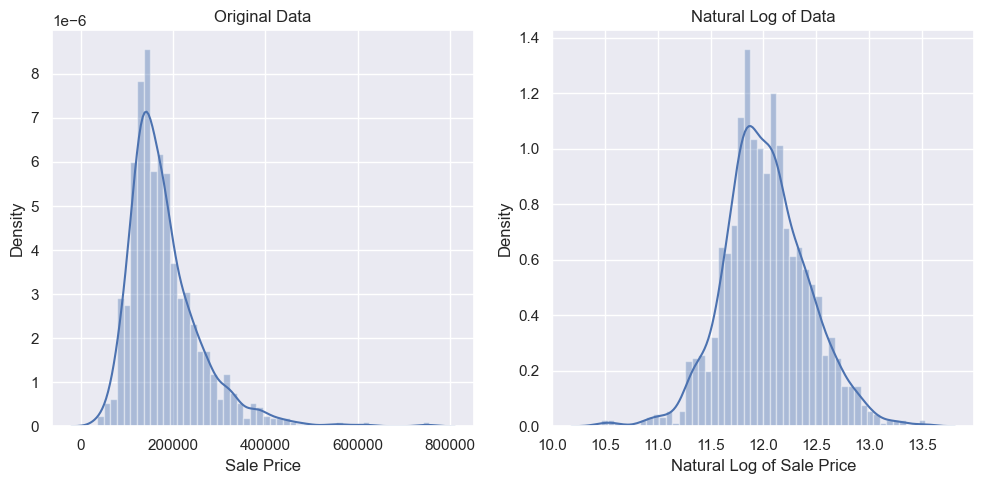

In [155]:
### Это позволяет получить нормальное распределение таргета
### Важно, например, для построения корректной
### С точки зрения статистических свойств
### Линейной модели.
### Хотя здесь мы будем строить ансамбли деревьев, 
### И это не особо интересно.

sns.set(rc={'figure.figsize':(15,10)})

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(y, bins=50)
plt.title('Original Data')
plt.xlabel('Sale Price')

plt.subplot(1,2,2)
sns.distplot(log_target, bins=50)
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of Sale Price')
plt.tight_layout()

### В начале поработаем с пропусками!

Если в какой-либо колонке оказывается достаточно много пропусков, обычно советуют от них избавляться. Мотивировано это тем, что в таких фичах мы можем наблюдать серьезный недостаток информативности, а заполнение пропусков может лишь внести лишнего шума в данные.

Избавьтесь от всех колонок, в которых пропусков оказывается больше 15%. (1б)

In [156]:
missing_ratio = df.isnull().sum() / len(df)
columns_to_drop = missing_ratio[missing_ratio > 0.15]
columns_to_drop

LotFrontage    0.177397
Alley          0.937671
MasVnrType     0.597260
FireplaceQu    0.472603
PoolQC         0.995205
Fence          0.807534
MiscFeature    0.963014
dtype: float64

In [157]:
### Your code is here
missing_ratio = df.isnull().sum() / len(X)
columns_to_drop = missing_ratio[missing_ratio > 0.15].index

df = df.drop(columns=columns_to_drop)
df 

MSSubClass MSZoning  LotArea Street LotShape LandContour Utilities  \
0             60       RL     8450   Pave      Reg         Lvl    AllPub   
1             20       RL     9600   Pave      Reg         Lvl    AllPub   
2             60       RL    11250   Pave      IR1         Lvl    AllPub   
3             70       RL     9550   Pave      IR1         Lvl    AllPub   
4             60       RL    14260   Pave      IR1         Lvl    AllPub   
...          ...      ...      ...    ...      ...         ...       ...   
1455          60       RL     7917   Pave      Reg         Lvl    AllPub   
1456          20       RL    13175   Pave      Reg         Lvl    AllPub   
1457          70       RL     9042   Pave      Reg         Lvl    AllPub   
1458          20       RL     9717   Pave      Reg         Lvl    AllPub   
1459          20       RL     9937   Pave      Reg         Lvl    AllPub   

     LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
0       Inside       Gtl      CollgCr       Norm       Norm     1Fam   
1          FR2       Gtl      Veenker      Feedr       Norm     1Fam   
2       Inside       Gtl      CollgCr       Norm       Norm     1Fam   
3       Corner       Gtl      Crawfor       Norm       Norm     1Fam   
4          FR2       Gtl      NoRidge       Norm       Norm     1Fam   
...        ...       ...          ...        ...        ...      ...   
1455    Inside       Gtl      Gilbert       Norm       Norm     1Fam   
1456    Inside       Gtl       NWAmes       Norm       Norm     1Fam   
1457    Inside       Gtl      Crawfor       Norm       Norm     1Fam   
1458    Inside       Gtl        NAmes       Norm       Norm     1Fam   
1459    Inside       Gtl      Edwards       Norm       Norm     1Fam   

     HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle  \
0        2Story            7            5       2003          2003     Gable   
1        1Story            6            8       1976          1976     Gable   
2        2Story            7            5       2001          2002     Gable   
3        2Story            7            5       1915          1970     Gable   
4        2Story            8            5       2000          2000     Gable   
...         ...          ...          ...        ...           ...       ...   
1455     2Story            6            5       1999          2000     Gable   
1456     1Story            6            6       1978          1988     Gable   
1457     2Story            7            9       1941          2006     Gable   
1458     1Story            5            6       1950          1996       Hip   
1459     1Story            5            6       1965          1965     Gable   

     RoofMatl Exterior1st Exterior2nd  MasVnrArea ExterQual ExterCond  \
0     CompShg     VinylSd     VinylSd       196.0        Gd        TA   
1     CompShg     MetalSd     MetalSd         0.0        TA        TA   
2     CompShg     VinylSd     VinylSd       162.0        Gd        TA   
3     CompShg     Wd Sdng     Wd Shng         0.0        TA        TA   
4     CompShg     VinylSd     VinylSd       350.0        Gd        TA   
...       ...         ...         ...         ...       ...       ...   
1455  CompShg     VinylSd     VinylSd         0.0        TA        TA   
1456  CompShg     Plywood     Plywood       119.0        TA        TA   
1457  CompShg     CemntBd     CmentBd         0.0        Ex        Gd   
1458  CompShg     MetalSd     MetalSd         0.0        TA        TA   
1459  CompShg     HdBoard     HdBoard         0.0        Gd        TA   

     Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1  \
0         PConc       Gd       TA           No          GLQ         706   
1        CBlock       Gd       TA           Gd          ALQ         978   
2         PConc       Gd       TA           Mn          GLQ         486   
3        BrkTil       TA       Gd           No          ALQ         216   
4         PConc

Вещественные колонки заполните медианным значением по фиче, а категориальные - самой популярной по колонке категорией. (2б)

Заметьте, что колонки `MoSold`, `YrSold`, `GarageYrBlt`, `YearBuilt`, `YearRemodAdd` хоть в таблице не являются типами `object`, вряд ли их справедливо использовать как вещественные. Обработайте их как категориальные.

In [158]:
special_categorical_cols = ['MoSold', 'YrSold', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd']

for col in special_categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype(str)

In [159]:
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(include=[np.number]).columns
categorical_columns, numerical_columns

(Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
        'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond',
        'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
        'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
        'KitchenQual', 'Functional', 'GarageType', 'GarageYrBlt',
        'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'MoSold',
        'YrSold', 'SaleType', 'SaleCondition'],
       dtype='object'),
 Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
        'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
        '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
        'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
        'Fireplace

In [160]:
for col in categorical_columns:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(X[col].mode().iloc[0])

for col in numerical_columns:
    if df[col].isnull().sum() > 0:
        median_value = df[col].median()
        df[col] = df[col].fillna(median_value)

df.isnull().sum().sum()

np.int64(0)

In [161]:
df.to_csv('processed_data.csv', sep=',', index=False)

In [163]:
### Отложенная выборка

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    log_target, 
                                                    test_size=0.25, 
                                                    random_state=1)

Напишите трансформер, который будет делать следующее:

1. Масштабирование через StandardScaler для вещественных колонок
2. Кодирование через OneHotEncoder для категориальных, содержащих менее, чем 5 уникальных значений
3. Кодирование через TargetEncoder для всех остальных категориальных

Для этого советуем воспользоваться библиотекой `category_encoders` помимо `sklearn`.

А так же классом `ColumnTransformer` из `sklearn.compose`.

P.S. Напомним, что для деревьев процедура StandardScaling не обязательна (решающие деревья нечувствительны к масштабу). Тем не менее, это может сделать обучение модели менее тяжелым (хранить большие числа сложно для задач с большим количеством данных).

In [132]:
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import StandardScaler

### Your code is here
cols_for_ohe = [x for x in categorical_columns if X_train[x].nunique() < 5]
cols_for_mte = [x for x in categorical_columns if X_train[x].nunique() >= 5]
numeric_cols = list(X_train.select_dtypes(exclude='object').columns)

### сохраним индексы этих колонок

cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]
numeric_cols_idx = [list(X_train.columns).index(col) for col in numeric_cols]

In [133]:
t = [('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
     ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx),
     ('StandardScaler', StandardScaler(), numeric_cols_idx)]

col_transform = ColumnTransformer(transformers=t)

In [134]:
col_transform.fit(X_train, y_train)

ColumnTransformer(transformers=[('OneHotEncoder', OneHotEncoder(),
                                 [3, 4, 5, 6, 8, 23, 26, 27, 28, 36, 37, 49, 55,
                                  60]),
                                ('MeanTargetEncoder', TargetEncoder(),
                                 [1, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20,
                                  21, 24, 25, 29, 31, 35, 38, 51, 53, 54, 58,
                                  59, 68, 69, 70, 71]),
                                ('StandardScaler', StandardScaler(),
                                 [0, 2, 14, 15, 22, 30, 32, 33, 34, 39, 40, 41,
                                  42, 43, 44, 45, 46, 47, 48, 50, 52, 56, 57,
                                  61, 62, 63, 64, 65, 66, 67])])

In [135]:
col_transform.transform(X_test)

array([[ 1.        ,  0.        ,  1.        , ..., -0.28304441,
        -0.06684663, -0.09061065],
       [ 1.        ,  0.        ,  1.        , ..., -0.28304441,
        -0.06684663, -0.09061065],
       [ 1.        ,  0.        ,  0.        , ..., -0.28304441,
        -0.06684663, -0.09061065],
       ...,
       [ 1.        ,  0.        ,  1.        , ..., -0.28304441,
        -0.06684663, -0.09061065],
       [ 1.        ,  0.        ,  0.        , ..., -0.28304441,
        -0.06684663, -0.09061065],
       [ 1.        ,  0.        ,  0.        , ..., -0.28304441,
        -0.06684663, -0.09061065]])

Посмотрите, как на наших данных справляется одно Решающее Дерево с дефолтными гиперпараметрами. Добавьте написанный ранее трансформер в модель. (1б)

In [136]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### Your code is here
pipe_dt = Pipeline([("column_transformer",
                     col_transform),
                     
                    ("decision_tree", 
                     DecisionTreeRegressor())])

pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [3, 4, 5, 6, 8, 23, 26, 27,
                                                   28, 36, 37, 49, 55, 60]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [1, 7, 9, 10, 11, 12, 13, 16,
                                                   17, 18, 19, 20, 21, 24, 25,
                                                   29, 31, 35, 38, 51, 53, 54,
                                                   58, 59, 68, 69, 70, 71]),
                                                 ('StandardScaler',
                                                  StandardScaler(),
                                                  [0, 2, 14, 15, 22, 30, 32, 33,
                                                   34, 39, 40, 41, 42, 43, 44,
                                                   45, 46, 47, 48, 50, 52, 56,
                                                   57, 61, 62, 63, 64, 65, 66,
                                                   67])])),
                ('decision_tree', DecisionTreeRegressor())])

In [137]:
train_preds = pipe_dt.predict(X_train)
test_preds = pipe_dt.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)


print(f"Качество на трейне: {train_error.round(3)}")
print(f"Качество на тесте: {test_error.round(3)}")

Качество на трейне: 0.0
Качество на тесте: 0.053


Справляется даже без контроля переобучения!

Посмотрим на перформанс Случайного Леса! Подберите параметры по отложенной выборке по данной сетке `param_grid`. Помните, что подбирать количество деревьев не супер обязательно, достаточно поставить их побольше. Что произошло с качеством модели по сравнению с одиноким деревом? (2б)

In [138]:
param_grid = {
    "random_forest__max_depth": [10, 15, 20],
    "random_forest__min_samples_split": [2, 5, 10],
    "random_forest__min_samples_leaf": [1, 3, 5]
}

pipe_rf = Pipeline([("column_transformer",
                     col_transform),
                     
                    ("random_forest", 
                     RandomForestRegressor())])

pipe_dt.fit(X_train, y_train)

### Your code is here
search = GridSearchCV(pipe_rf, 
                      param_grid, 
                      scoring='neg_mean_squared_error',
                      verbose=1)

search.fit(X_train, y_train)

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

print(f"Качество лучшей модели на финальном тесте: {search.score(X_test, y_test)}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameter (CV score=-0.02185):
{'random_forest__max_depth': 20, 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 2}
Качество лучшей модели на финальном тесте: -0.01862726223474903


Попробуем теперь поэкспериментировать с бэггингами. 

Постройте бэггинги с 100 базовыми моделями (и остальными стандартными параметрами) над линейной регрессией, деревом и случайным лесом (бэггинг над бэггингом!). 

Какое качество у каждой модели на тесте?

Какой алгоритм получился лучше с точки зрения качества на тесте? (2б)

In [139]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor

base_pipe = Pipeline([("column_transformer",
                       col_transform),
                  
                     ("LinearRegression", 
                      LinearRegression())])

bagging = BaggingRegressor(estimator=base_pipe,
                            n_estimators=100, random_state=32)

bagging.fit(X_train, y_train)
train_preds = bagging.predict(X_train)
test_preds = bagging.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)


print(f"Качество на трейне: {train_error.round(3)}")
print(f"Качество на тесте: {test_error.round(3)}")

Качество на трейне: 0.015
Качество на тесте: 0.018


In [140]:
base_pipe = Pipeline([("column_transformer",
                       col_transform),
                  
                     ("RandomForestRegressor", 
                      RandomForestRegressor())])

bagging = BaggingRegressor(estimator=base_pipe,
                            n_estimators=100, random_state=32)

bagging.fit(X_train, y_train)
train_preds = bagging.predict(X_train)
test_preds = bagging.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)


print(f"Качество на трейне: {train_error.round(3)}")
print(f"Качество на тесте: {test_error.round(3)}")

Качество на трейне: 0.006
Качество на тесте: 0.019


In [141]:
base_pipe = Pipeline([("column_transformer",
                       col_transform),
                  
                     ("DecisionTreeRegressor", 
                      DecisionTreeRegressor())])

bagging = BaggingRegressor(estimator=base_pipe,
                            n_estimators=100, random_state=32)

bagging.fit(X_train, y_train)
train_preds = bagging.predict(X_train)
test_preds = bagging.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)


print(f"Качество на трейне: {train_error.round(3)}")
print(f"Качество на тесте: {test_error.round(3)}")

Качество на трейне: 0.003
Качество на тесте: 0.02


Улучшил ли бэггинг над Лесом качество по сравнению с одним Лесом с точки зрения как качества на тесте, так и на трейне. Как это можно объяснить? Как думаете, много ли смысла в использовании бэггинга над линейными моделями? Выбрали бы вы в данной ситуации именно их в качестве базовых?

### Добавим новые фичи!

Создайте следующие четыре новые вещественные фичи:

1. Отношения площади 1 этажа к общей площади (колонки 1stFlrSF и GrLivArea, в %)
2. Отношение Площади завершенного фундамента первого типа к общей площади фундамента (колонки BsmtFinSF1 и TotalBsmtSF, в %)
3. Возраст дома (между YearBuilt и YrSold)
4. Общая площадь самого дома и фундамента/цоколя (1stFlrSF + 2ndFlrSF + TotalBsmtSF)

Обучите заново Случайный лес и найдите лучшие гиперпараметры на старой сетке.

Улучшили ли качество модели новые фичи? (4б)

In [164]:
### Your code is here
X_train_new = X_train.copy()
X_test_new = X_test.copy()

# Преобразуем годовые колонки в числовой тип
X_train_new['YrSold'] = pd.to_numeric(X_train_new['YrSold'], errors='coerce')
X_train_new['YearBuilt'] = pd.to_numeric(X_train_new['YearBuilt'], errors='coerce')
X_test_new['YrSold'] = pd.to_numeric(X_test_new['YrSold'], errors='coerce')
X_test_new['YearBuilt'] = pd.to_numeric(X_test_new['YearBuilt'], errors='coerce')

# 1. Отношение площади 1 этажа к общей площади (в %)
X_train_new['1stFlrSF_to_GrLivArea_ratio'] = (X_train_new['1stFlrSF'] / X_train_new['GrLivArea']) * 100
X_test_new['1stFlrSF_to_GrLivArea_ratio'] = (X_test_new['1stFlrSF'] / X_test_new['GrLivArea']) * 100

# 2. Отношение площади завершенного фундамента первого типа к общей площади фундамента (в %)
X_train_new['BsmtFinSF1_to_TotalBsmtSF_ratio'] = (X_train_new['BsmtFinSF1'] / X_train_new['TotalBsmtSF']) * 100
X_test_new['BsmtFinSF1_to_TotalBsmtSF_ratio'] = (X_test_new['BsmtFinSF1'] / X_test_new['TotalBsmtSF']) * 100

# 3. Возраст дома (между YearBuilt и YrSold)
X_train_new['HouseAge'] = X_train_new['YrSold'] - X_train_new['YearBuilt']
X_test_new['HouseAge'] = X_test_new['YrSold'] - X_test_new['YearBuilt']

# 4. Общая площадь самого дома и фундамента/цоколя
X_train_new['TotalArea'] = X_train_new['1stFlrSF'] + X_train_new['2ndFlrSF'] + X_train_new['TotalBsmtSF']
X_test_new['TotalArea'] = X_test_new['1stFlrSF'] + X_test_new['2ndFlrSF'] + X_test_new['TotalBsmtSF']

In [165]:
param_grid = {
    "random_forest__max_depth": [10, 15, 20],
    "random_forest__min_samples_split": [2, 5, 10],
    "random_forest__min_samples_leaf": [1, 3, 5]
}

pipe_rf = Pipeline([
    ("column_transformer", col_transform),
    ("random_forest", RandomForestRegressor(
        random_state=42, 
        n_jobs=-1,      
        n_estimators=100  
    ))
])


### Your code is here
search = GridSearchCV(pipe_rf, 
                      param_grid, 
                      scoring='neg_mean_squared_error',
                      verbose=1)

search.fit(X_train_new, y_train)

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

print(f"Качество лучшей модели на финальном тесте: {search.score(X_test_new, y_test)}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameter (CV score=-0.02170):
{'random_forest__max_depth': 20, 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 2}
Качество лучшей модели на финальном тесте: -0.018579648768910592
